# select utts to do various things based on a corpus

50% fastpitch
* 90% train
* 10% dev 

50% respeller
* 80% train
* 10% dev
* 10% test
    
The utterances used to train fastpitch should have more prototypical english spellings

Method 1:
* Add utts to respeller corpus that have words that have freq of 1
* then 2
* then 3... 
* Until we form 50% of the total number of graphemes

Method 2:
* use G2P model + phoneme dict

Method 3:
* use avg perplexity to rank words/utts from pretrained grapheme based LM

In [128]:
import string
from collections import Counter
import random
import os
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
# load text data
with open('/home/s1785140/data/ljspeech_fastpitch/wav_text_filelist.txt') as f:
    lines = f.readlines()

In [130]:
def only_alphabet(s):
    rv = []
    for c in s:
        if c in string.ascii_lowercase + ' ':
            rv.append(c)
    return ''.join(rv)

def replace(s1, c1, c2):
    s2 = []
    for c in s1:
        if c == c1:
            s2.append(c2)
        else:
            s2.append(c)
    return ''.join(s2)        

def tokenise(s):
    # replace hyphen with space to treat word as two separate words rather than one word
    # remove all other punc so we can analyse just the word tokens
    s = s.lower()
    return only_alphabet(replace(s, '-', ' ')).split(' ')

uttid2rawtext = {}
for l in lines:
    utt_id = l.split('.wav')[0].split('/')[-1]
    text = l.split('|')[-1].rstrip('\n')
    uttid2rawtext[utt_id] = text

# build up word counter
def get_word_freq(uttids, uttid2rawtext):
    # get wordfreq for the words in the utts according to uttids
    uttid2words = {}
    word_freq = Counter()
    for utt_id in uttids:  
        text = uttid2rawtext[utt_id]
        words = set(tokenise(text)) # remove duplicates
        uttid2words[utt_id] = words
        for word in words:
            word_freq[word] += 1
    return word_freq, uttid2words

word_freq, uttid2words = get_word_freq(uttid2rawtext.keys(), uttid2rawtext)

In [131]:
# most common
word_freq.most_common(10)

[('the', 9641),
 ('of', 6379),
 ('and', 5384),
 ('to', 5037),
 ('in', 4099),
 ('a', 3600),
 ('was', 3311),
 ('that', 2611),
 ('he', 2136),
 ('his', 1693)]

In [132]:
# least common
# sorted_ascending = sorted(word_freq.items(), key=lambda x: (x[1], x[0]))
sorted_ascending = sorted(word_freq.items(), key=lambda x: x[1])
sorted_ascending[:10]

[('differs', 1),
 ('chinese', 1),
 ('netherlands', 1),
 ('woodcutters', 1),
 ('letterpress', 1),
 ('productions', 1),
 ('craftsmen', 1),
 ('shapeliness', 1),
 ('perfection', 1),
 ('calligraphy', 1)]

In [133]:
def utts_with_word(uttid2words, word):
    # find the utt ids that contain a word
    uttids = []
    for uttid, words in uttid2words.items():
        if word in words:
            uttids.append(uttid)
    return uttids

In [134]:
# respeller utterances
TOTAL_UTTS = 13100
assert TOTAL_UTTS == len(lines)

# what proportion of corpus is assigned to respeller (rest is assigned to tts training/eval)
respeller_corpus_ratio = 0.5
respeller_corpus_N = int(TOTAL_UTTS*respeller_corpus_ratio)

# add utts to respeller corpus 
# (also keep track of the lowfreq_word it contains)
respeller_utt_to_lowfreq_word = dict()
for word, freq in sorted_ascending:
    utt_ids = utts_with_word(uttid2words, word)
    for utt_id in utt_ids:
        respeller_utt_to_lowfreq_word[utt_id] = (word, freq)
        del uttid2words[utt_id] # remove this utt from candidate list    
        
    if len(respeller_utt_to_lowfreq_word) > respeller_corpus_N:
        break # have enough utts for respeller

In [135]:
len(respeller_utt_to_lowfreq_word.keys())

6551

In [136]:
len(uttid2words.keys())

6549

In [137]:
assert TOTAL_UTTS == len(respeller_utt_to_lowfreq_word.keys()) + len(uttid2words.keys())

In [138]:
# Create train dev test splits
def get_datasplits(
    utt_ids, 
    ratios,  # [train, dev, test]
):
    random.shuffle(utt_ids)
    N = len(utt_ids)
    assert sum(ratios) == 1
    train_ratio, dev_ratio, test_ratio = ratios 
    train = utt_ids[:int(train_ratio*N)]
    if test_ratio != 0.0:
        dev = utt_ids[int(train_ratio*N):int(train_ratio*N)+int(dev_ratio*N)]
        test = utt_ids[int(train_ratio*N)+int(dev_ratio*N):]
    else:
        dev = utt_ids[int(train_ratio*N):]
        test = []
    assert N == len(train) + len(dev) + len(test), f"{N} == {len(train)} + {len(dev)} + {len(test)}"
    print(f"{N} == {len(train)}(train) + {len(dev)}(dev) + {len(test)}(test)")
    return train, dev, test

In [139]:
# write utt ids to disk

def write_utt_ids(uttids, outdir, outfile):
    uttids.sort()
    lines = []
    for uttid in uttids:
        line = f'{uttid}\n'
        lines.append(line)
    with open(os.path.join(outdir, outfile), 'w') as f:
        f.writelines(lines)

outdir = '/home/s1785140/data/ljspeech_fastpitch'
outfile = 'respeller_uttids.txt'
respeller_utt_ids = list(respeller_utt_to_lowfreq_word.keys())
write_utt_ids(respeller_utt_ids, outdir, outfile)

In [140]:
train, dev, test = get_datasplits(respeller_utt_ids, [0.8, 0.1, 0.1])

6551 == 5240(train) + 655(dev) + 656(test)


In [141]:
# [train, dev, test]
tts_utt_ids = list(uttid2words.keys())
train, dev, test = get_datasplits(tts_utt_ids, [0.975, 0.025, 0.0])

6549 == 6385(train) + 164(dev) + 0(test)


In [142]:
# write files to disk for training fastpitch
def write_fastpitch_meta_file(uttids, outdir, outfile):
    uttids.sort()
    lines = []
    for uttid in uttids:
        line = f'mels/{uttid}.pt|durations/{uttid}.pt|pitches/{uttid}.pt|{uttid2rawtext[uttid]}\n'
        lines.append(line)
    with open(os.path.join(outdir, outfile), 'w') as f:
        f.writelines(lines)

In [143]:
outdir = '/home/s1785140/data/ljspeech_fastpitch'
outfile = 'train_meta_half.txt'
write_fastpitch_meta_file(train, outdir, outfile)

outdir = '/home/s1785140/data/ljspeech_fastpitch'
outfile = 'val_meta_half.txt'
write_fastpitch_meta_file(dev, outdir, outfile)

# print metrics for a set of utt ids

In [144]:
# plot word freq
respeller_word_freq, uttid2words = get_word_freq(respeller_utt_ids, uttid2rawtext)
tts_word_freq, uttid2words = get_word_freq(tts_utt_ids, uttid2rawtext)

# df
respeller_df = pd.DataFrame(respeller_word_freq.most_common(), columns=['words', 'count'])
respeller_df.head()

,words,count
0,the,4966
1,of,3471
2,and,3152
3,to,2593
4,in,2125


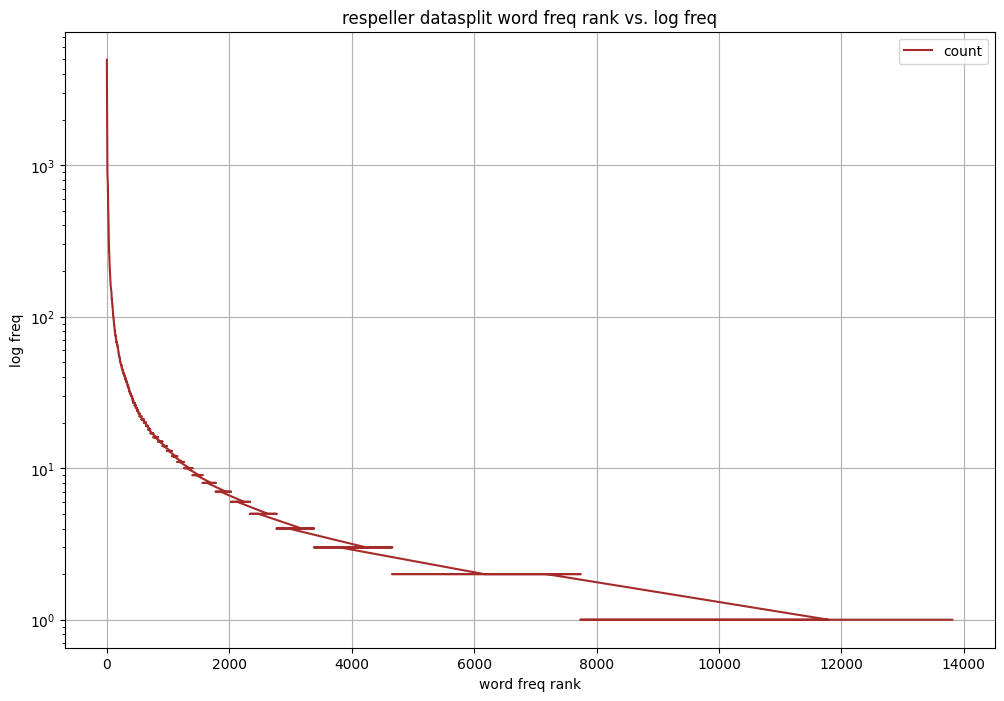

In [145]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot line graph 
# (settings @ https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.plot.html)
respeller_df.sort_values(by='count').plot.line(
    # x='words', # sets word on the X-Axis.
    use_index=True, # sets the DataFrame Index on the X-Axis.
    y='count',
    ax=ax,
    color="brown",
    logy=True,
    grid=True,
    title='respeller datasplit word freq rank vs. log freq',
    xlabel='word freq rank',
    ylabel='log freq'
)
plt.show()

In [146]:
# PER for g2p
# avg over corpus
# avg over utt
# avg over word

# plot whether phone error rate correlates with corpus frequency for word

# compare two sets of utt ids

In [147]:
# how many words in respellers data but not in tts
oov_counter = Counter()
for word, count in respeller_word_freq.most_common():
    if word not in tts_word_freq:
        oov_counter[word] += count
print('original LJ speech corpus has', len(word_freq), 'wordtypes')
print('tts corpus has', len(tts_word_freq), 'wordtypes')
print('respeller corpus has', len(respeller_word_freq), 'wordtypes')
print('there are', len(oov_counter), 'words that are in respeller corpus but not in tts')

original LJ speech corpus has 14001 wordtypes
tts corpus has 5657 wordtypes
respeller corpus has 13812 wordtypes
there are 8344 words that are in respeller corpus but not tts


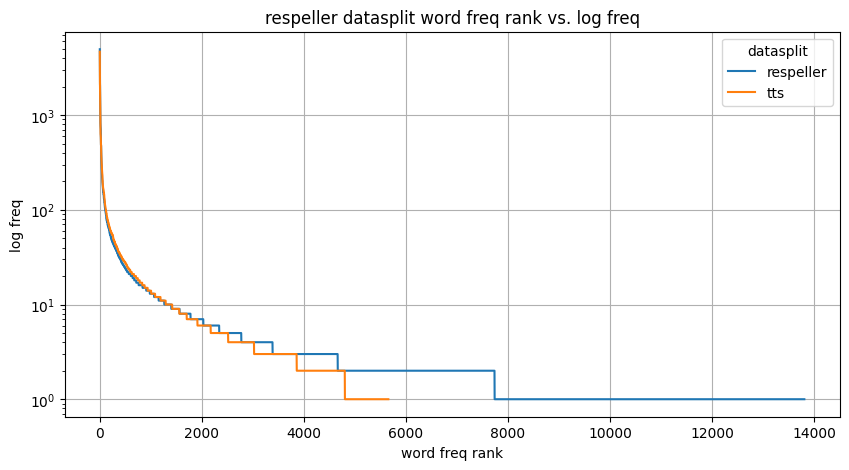

In [150]:
# word freqs
# sample data
respeller_words = [['respeller', i, count] for i, (word, count) in enumerate(respeller_word_freq.most_common())]
tts_words = [['tts', i, count] for i, (word, count) in enumerate(tts_word_freq.most_common())]

df = pd.DataFrame(
    respeller_words + tts_words,
    columns=['datasplit', 'x', 'count']
)

# pivot the data into the correct shape
df = df.pivot(index='x', columns='datasplit', values='count')

# display(df)

# plot the pivoted dataframe; if the column names aren't colors, remove color=df.columns
df.plot(
    # color=df.columns, 
    figsize=(10, 5),
    # use_index=True, # sets the DataFrame Index on the X-Axis.
    logy=True,
    grid=True,
    title='respeller datasplit word freq rank vs. log freq',
    xlabel='word freq rank',
    ylabel='log freq'
)
plt.show()

In [149]:
# overlapping words

# words not overlap